# Taller 4 - Representación y modelado

In [33]:
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import re # Biblioteca para realizar emparejamiento de expresiones regulares (hilos de caracteres)
import os
import sys
import skimage.io as imgio
import skimage as skim
from sklearn.model_selection import train_test_split

import numpy as np
import numpy.random as rng
import cv2 as cv

## Ejercicio 1 - Representaciones para clasificación de células

En los cuadernos de práctico 4-1 y 4-2 se discutió la importancia de elegir una representación adecuada para el problema que quiero resolver, y cómo los resultados del aprendizaje pueden depender considerablemente de la representación usada.

En este ejercicio implementaremos un clasificador que indique el tipo de glóbulo blanco (GB) presente en imágenes de microscopía. Para ello utilizaremos 3 representaciones bien distintas y compararemos los resultados obtenidos con cada una:

* 1) Una representación desarrollada a mano a partir de conocimiento del problema específico
* 2) Una representación de imágenes genérica que tiene invarianza a movimientos y rotación
* 3) Una representación lineal, que se obtiene combinando linealmente los valores de los píxeles. Esta se obtiene mediante PCA


Comenzamos importando las imágenes y las etiquetas de internet

In [34]:
#!wget -O data.zip "https://www.dropbox.com/scl/fi/92aueoj2lh5f6u4pymqrt/JPEGImages.zip?rlkey=6uz6j9imt2u66lryniyatpz9v&st=tgp96hqy&dl=1"
#!unzip data.zip
#!wget -qO etiquetas.csv https://www.dropbox.com/s/jk1qem0s3sa94m8/labels.csv?dl=0

Luego cargamos las imagenes y las etiquetas en variables, y hacemos un poco de limpieza, descartando aquellas imágenes sin etiqueta, o con más de un GB. También imprimimos el tamaño del array que contiene las imágenes.

In [35]:
## Cargar las imagenes
#image_names = sorted([os.path.join('JPEGImages', f) for f in os.listdir('JPEGImages') if os.path.isfile(os.path.join('data', f))])
#cellImages = np.empty((480, 640, 3, 0), dtype="uint8") #creamos un array vacío para ir llenando con imagenes
#imNumber = list() #creamos una lista para ir guardando el número de las imágenes
#for i,fname in enumerate(image_names):
#  tmpIm = plt.imread(fname)
#  tmpIm = tmpIm.reshape(480, 640, 3, 1)
#  cellImages = np.append(cellImages, tmpIm, axis=3)
#  imNumber.append(int(fname[18:21]))
#
## Cargar las etiquetas de las imagenes
#etiquetas = pd.read_csv("etiquetas.csv")
#etiquetas = etiquetas[etiquetas['Image'].isin(imNumber)].reset_index()
#
## Removemos imagen sin etiqueta
#etiquetas = etiquetas.drop(index=106).reset_index()
#cellImages = np.delete(cellImages, 106, axis=3)
#
## Removemos imagenes con etiquetas dobles o con muy pocas instancias
#tiposCelulares = ['NEUTROPHIL', 'MONOCYTE', 'EOSINOPHIL', 'LYMPHOCYTE']
#indicesImValidas = [ind for ind, x in enumerate(etiquetas['Category'].tolist()) if x in tiposCelulares]
#etiquetas = etiquetas.iloc[indicesImValidas,:]
#cellImages = cellImages[:,:,:,indicesImValidas]
#
#print(f"El array de datos que contiene las imágenes tiene dimensión {cellImages.shape}")
#

In [36]:
# Cargar las etiquetas de las imagenes
etiquetas = pd.read_csv("blood_labels.csv")

# Cargar las imagenes
dir_img = 'blood_images'
image_names = sorted([os.path.join(dir_img, f) for f in os.listdir(dir_img) if os.path.isfile(os.path.join(dir_img, f))])
cellImages = np.empty((480, 640, 3, 0), dtype="uint8") #creamos un array vacío para ir llenando con imagenes
for i,fname in enumerate(image_names):
  tmpIm = plt.imread(fname)
  tmpIm = tmpIm.reshape(480, 640, 3, 1)
  cellImages = np.append(cellImages, tmpIm, axis=3)

# Removemos imagenes con etiquetas dobles o con muy pocas instancias
tiposCelulares = etiquetas['Category'].unique()

print(f"El array de datos que contiene las imágenes tiene dimensión {cellImages.shape}")


El array de datos que contiene las imágenes tiene dimensión (480, 640, 3, 347)


Del bloque de arriba vemos que el dataset cuenta con 347 imagenes a color (porque la 3ra dimensión vale 3, indicando que hay 3 canales de color), de 480x640 pixeles.

A continuación, como siempre, miramos nuestros datos. Abajo mostramos imágenes ejemplo para cada tipo de GB en el set de datos.


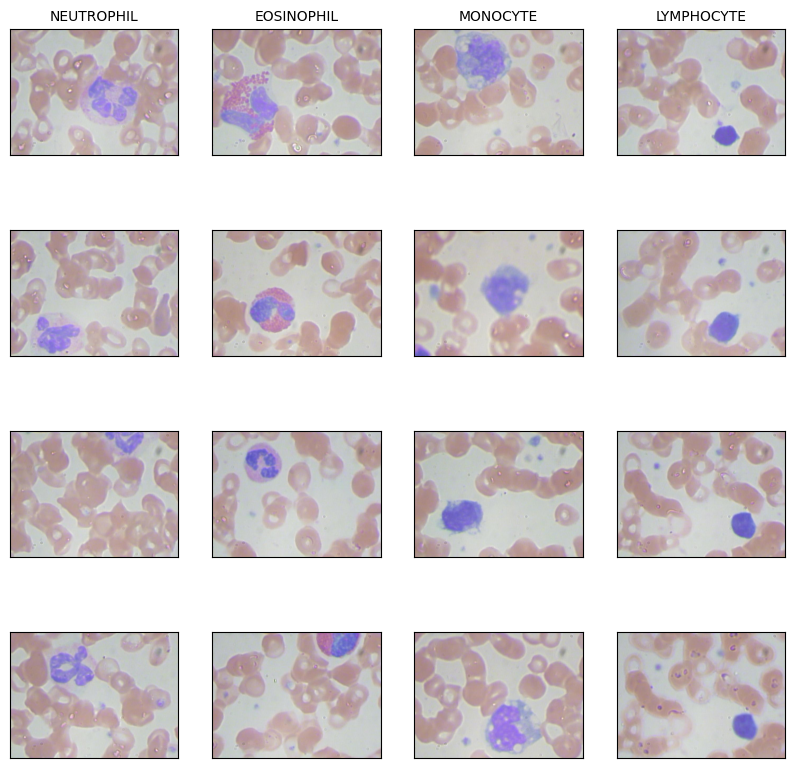

In [37]:
# Graficamos las imagenes, mostrando los 4 tipos de células
nPlot = 4
plt.figure(figsize=(10,10))
for t in range(len(tiposCelulares)):
    indicesCelula = np.where(etiquetas['Category'] == tiposCelulares[t])[0]
    imagenesTipo = cellImages[:,:,:,indicesCelula[0:nPlot]]
    for im in range(nPlot):
        plt.subplot(nPlot, len(tiposCelulares), t+1+im*len(tiposCelulares))
        if im==0:
            plt.title(tiposCelulares[t], fontdict={'fontsize': 10})
        plt.imshow(imagenesTipo[:,:,:,im])
        ax = plt.gca()
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
plt.show()

Vemos arriba que el dataset consiste de imágenes de microscopía, donde se expone al tejido a colorantes que son absorbidos de forma distinta por las distintas células y los distintos organelos dentro de las mismas. En las imágenes, se ven muchos glóbulos rojos, que no tienen núcleo y no absorben los colorantes nucleares. Por otro lado, se ve que los diferentes tipos de GB absorben el colorante nuclear, y que sus núcleos celulares (que contienen el ADN) se ven en la imagen de color azulado.

De la imagen de arriba parece claro que puede distinguirse el núcleo del GB de los otros elementos de la imagen mediante el color. Esto significa que quizás podemos seleccionar el canal de color adecuado que convierta a cada imagen multicolor en una imagen de escala de grises donde sea fácil identificar el núcleo.

Para ver qué canales de color permiten ver el núcleo, mostramos abajo por separado cada canal de color de las imágenes.

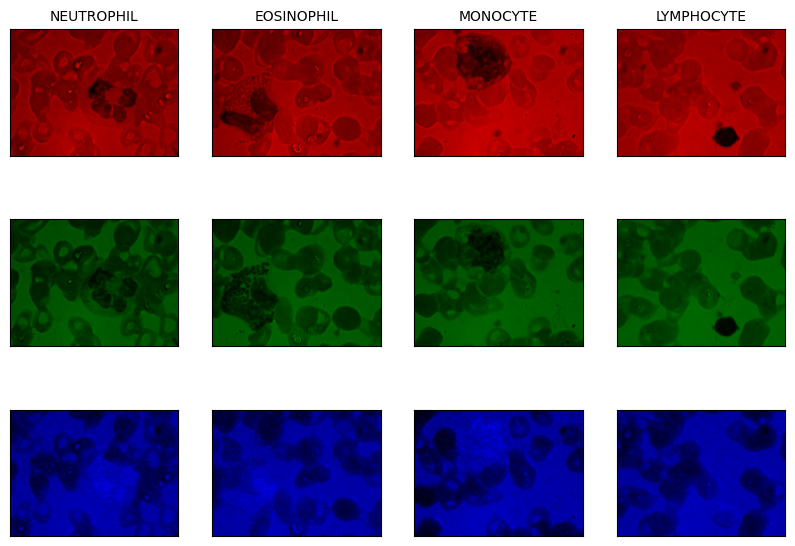

In [38]:
from matplotlib.colors import LinearSegmentedColormap
# creamos mapas de color rojo, verde y azul
rojos  = LinearSegmentedColormap.from_list(name="rojos",colors=["black","red"])
verdes = LinearSegmentedColormap.from_list(name="rojos",colors=["black","green"])
azules = LinearSegmentedColormap.from_list(name="rojos",colors=["black","blue"])
mapasColores = [rojos, verdes, azules]

# mostramos una imagen de cada tipo con las 3 escalas de color
plt.figure(figsize=(10, 7))
for t in range(len(tiposCelulares)):
    indicesCelula = np.where(etiquetas['Category'] == tiposCelulares[t])[0]
    imagenesTipo = cellImages[:,:,:,indicesCelula[0]]
    for ch in range(3):
        plt.subplot(3, len(tiposCelulares), t+1+ch*len(tiposCelulares))
        if ch==0:
            plt.title(tiposCelulares[t], fontdict={'fontsize': 10})
        plt.imshow(imagenesTipo[:,:,ch], cmap=mapasColores[ch])
        ax = plt.gca()
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
plt.show()

Vemos de las imagenes de arriba que el núcleo de los GB presenta una baja intensidad de colores rojos, y una alta intensidad de color azul. Por lo tanto, generamos nuevas imágenes tomando el canal de color azul, y restándole el canal de color rojo. Estas imágenes son monocromáticas (no tienen 3 colores, sino sólo intensidad de gris), y en ellas esperamos ver valores altos (es decir, imagen clara) en el núcleo de los GB, y valores bajos (imagen oscura) en los otros elementos.

Abajo generamos un nuevo array de imagenes haciendo esta resta de colores, y mostramos las imagenes resultantes en escala de grises.

Ahora la forma del array de imagenes es: (480, 640, 347)
Notamos que ya no tenemos la dimensión del canal de color, sino que ahora el array tiene 3 dimensiones: alto, ancho y el numero de imagen


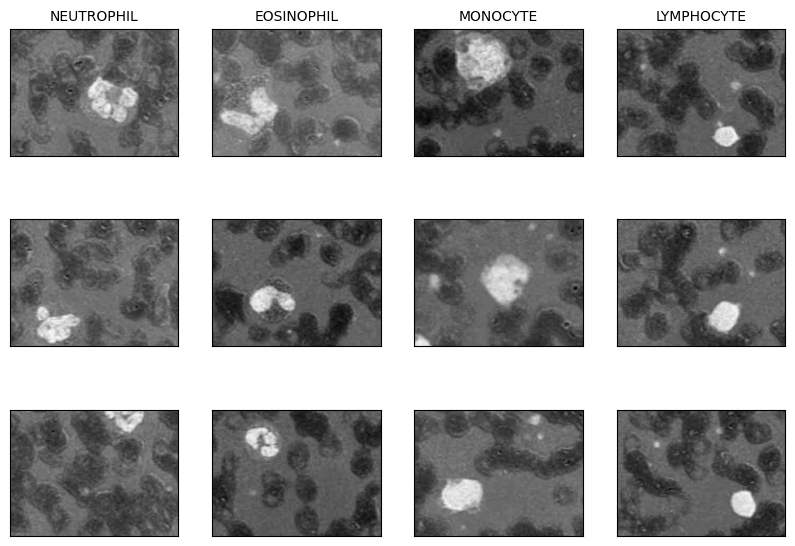

In [39]:
# las imagenes por default se codifican de una forma que solo admite valores entre 0-255. Cambiamos eso para hacer la resta
cellImages = cellImages.astype("int32")
# tomamos el canal azul (2) y le restamos el canal rojo (0)
imagenes1 = cellImages[:,:,2,:] - cellImages[:,:,0,:]
# le restamos el valor mínimo para llevar a 0 el valor mínimo, y recodificamos en el formato de las imagenes, uint8
imagenes1 = imagenes1 - np.min(imagenes1)
imagenes1 = imagenes1.astype("uint8")

print(f"Ahora la forma del array de imagenes es: {imagenes1.shape}")
print("Notamos que ya no tenemos la dimensión del canal de color, sino que ahora el array tiene 3 dimensiones: alto, ancho y el numero de imagen")

# graficamos 3 imagenes de cada tipo en la escala de grises
nPlot = 3
plt.figure(figsize=(10,7))
for t in range(len(tiposCelulares)):
    indicesCelula = np.where(etiquetas['Category'] == tiposCelulares[t])[0]
    imagenesTipo = imagenes1[:,:,indicesCelula[0:nPlot]]
    for im in range(nPlot):
        plt.subplot(nPlot, len(tiposCelulares), t+1+im*len(tiposCelulares))
        if im==0:
            plt.title(tiposCelulares[t], fontdict={'fontsize': 10})
        plt.imshow(imagenesTipo[:,:,im], cmap='gray')
        ax = plt.gca()
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
plt.show()

En las imágenes de arriba se ve que el núcleo de los GB es claramente identificable por su intesidad. Un último paso que podemos hacer, para deshacernos del ruido que introduce en el análisis el fondo de la imagen con células que no nos interesan, es aplicar un umbral y marcar con 0 los píxeles que no superan el umbral, y con 1 los píxeles que sí lo superan. Eligiendo el umbral adecuado podemos conseguir imágenes en que lo único que se vea sea el núcleo de los GB.

Abajo generamos un nuevo array de imagenes aplicándoles un umbral, y mostramos las imágenes resultantes. También aplicamos un poco de limpieza para borrar la señal producida por las plaquetas, que se ven como pequeños puntos luminosos en las imágenes.

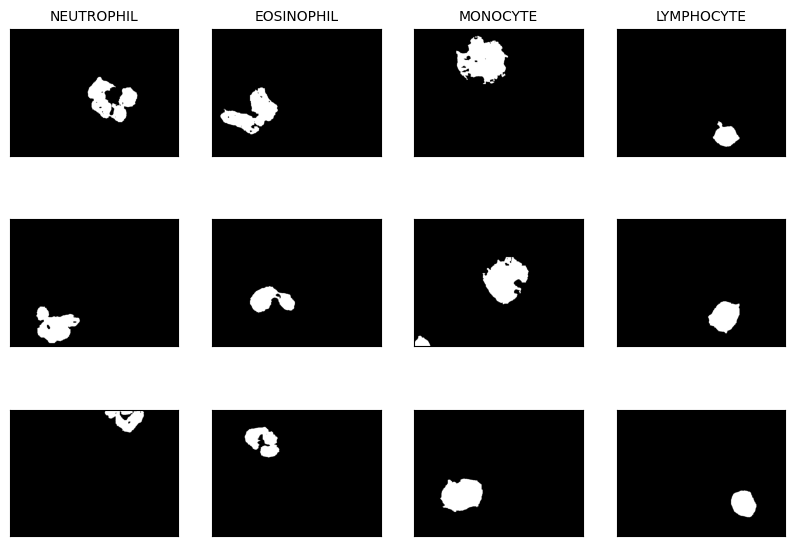

In [40]:
from scipy import ndimage as ndi

# aplicamos un umbral a las imagenes, obteniendo imagenes binarias
imagenesBin = (imagenes1 > 130)

# luego aplicamos un poco de procesamiento para eliminar los núcleos de las plaquetas
for im in range(imagenesBin.shape[2]):
  label_objects, nb_labels = ndi.label(imagenesBin[:,:,im])
  sizes = np.bincount(label_objects.ravel())
  mask_sizes = sizes > 1000
  mask_sizes[0] = 0
  imagenesBin[:,:,im] = mask_sizes[label_objects]

# mostramos algunas imagenes binarizadas
nPlot = 3
plt.figure(figsize=(10,7))
for t in range(len(tiposCelulares)):
    indicesCelula = np.where(etiquetas['Category'] == tiposCelulares[t])[0]
    imagenesTipo = imagenesBin[:,:,indicesCelula[0:nPlot]]
    for im in range(nPlot):
        plt.subplot(nPlot, len(tiposCelulares), t+1+im*len(tiposCelulares))
        if im==0:
            plt.title(tiposCelulares[t], fontdict={'fontsize': 10})
        plt.imshow(imagenesTipo[:,:,im], cmap='gray')
        ax = plt.gca()
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
plt.show()

Vemos arriba que conseguimos nuevas imágenes que indican claramente el núcleo del GB, y donde nos deshicimos de todo lo que lo rodea. En este proceso hicimos un cambio de representación importante, en el que descartamos mucha información de las imagenes, pero nos quedamos con un tipo de información específica: los píxeles que pertenecen al núcleo de los GB.

### Representación manual

Se puede ver a simple vista en las imagenes que los diferentes tipos de GB tienen núcleos celulares con formas, estructuras y tamaños diferentes. De hecho, una de las principales formas de identificar visualmente los tipos de GB es según las características de su núcleo. En esta [guía de histología](https://www.histology.leeds.ac.uk/blood/blood_wbc.php), por ejemplo, se señala que se puede identificar a los GB según cuantos lóbulos tiene su núcleo, el tamaño del mismo, y según la presencia de gránulos, que pueden verse como 'agujeros' en el núcleo.

Para construir nuestra primera representación del problema, usamos este conocimiento experto. En el bloque de código de abajo usamos herramientas estándar del paquete de procesamiento de imágenes *ndimage* de *scipy* para contar aproximadamente el **número de lóbulos** y el **número de agujeros** presentes en la 'mancha blanca' de cada imagen. Luego con Python base medimos el **ancho y el alto del núcleo**. Al final, separamos en sets de testeo y entrenamiento, e imprimimos la tabla de entrenamiento resultante.

**Ejercicio 1.1:** En el código de abajo dejamos una línea vacía para que usted calcule el **área del núcleo** en la imágen. Le sugerimos que lo haga sumando los píxeles de la imagen, que valen 1 si pertenecen al núcleo, y 0 en caso contrario. Puede usar la función *np.sum()*.

**Nota:** Note que las representaciones de arriba son aproximadamente **invariantes** a la rotación o el desplazmiento de la imagen (ej. estas transformaciones no afectan el área del núcleo)

In [41]:
# contar fragmentos
lobulos = []
agujeros = []
altura = []
ancho = []
area = []
for im in range(imagenesBin.shape[2]):
  # extraemos la imagen para anlizar
  imagenTemp = imagenesBin[:,:,im]
  # usamos erosion para cortar las uniones entre los lóbulos, y contar cuantas manchas sueltas quedan
  erodedIm = ndi.binary_erosion(imagenTemp, iterations=12)
  label_objects, nb_labels = ndi.label(erodedIm)
  lobulos.append(np.unique(nb_labels)[0])
  # tomamos el negativo de la imagen y contamos cuantas manchas hay, que son los "agujeros" en el núcleo
  negativeIm = 1 - imagenTemp
  label_objects, nb_labels = ndi.label(negativeIm)
  agujeros.append(np.unique(nb_labels)[0]-1)
  # medimos las coordenadas del objeto para tener tamaño
  sumaVert = np.sum(imagenTemp, axis=0)
  indicesVert = sumaVert.nonzero()[0]
  altura.append(indicesVert[len(indicesVert)-1] - indicesVert[0])
  sumaHor = np.sum(imagenTemp, axis=1)
  indicesHor = sumaHor.nonzero()[0]
  ancho.append(indicesHor[len(indicesHor)-1] - indicesHor[0])
  # contamos los pixeles para tener el area del nucleo
  areaTotal = np.sum(imagenTemp) ### LLENAR LINEA
  area.append(areaTotal)

# Juntamos los datos recolectados en un pandas dataframe
representacionManual = pd.DataFrame(list(zip(lobulos, agujeros, altura, ancho, area)),
                                    columns=['Lobulos', 'Agujeros', 'Alto', 'Ancho', 'Area'])

# dividimos los datos en entrenamiento y testeo
Xtrain_man, Xtest_man, ytrain_man, ytest_man = train_test_split(representacionManual, etiquetas['Category'],
                                                test_size=0.33, stratify=etiquetas['Category'], random_state=42)

# Estas 2 líneas son para resetear el índice de las filas. Es un detalle no importante
Xtrain_man.reset_index(inplace=True, drop=True)
Xtest_man.reset_index(inplace=True, drop=True)

print(Xtrain_man)
print(ytrain_man)

     Lobulos  Agujeros  Alto  Ancho   Area
0          5         9   158    154   9091
1          1         1   125     93   8108
2          1         4   154    138  11952
3          3         2   128    133  11428
4          2         4   136    173  13190
..       ...       ...   ...    ...    ...
227        1         0   120    119   8091
228        2         1   159    165  14791
229        1         1   148    121  10664
230        1         0   142    144  15754
231        6        16   168    143  11091

[232 rows x 5 columns]
130    NEUTROPHIL
42     NEUTROPHIL
135    NEUTROPHIL
310    NEUTROPHIL
182    NEUTROPHIL
          ...    
85     EOSINOPHIL
337    NEUTROPHIL
17     NEUTROPHIL
123    LYMPHOCYTE
126    EOSINOPHIL
Name: Category, Length: 232, dtype: object


### Representacion genérica de imágenes

Aunque en este problema particular hay algunas características útiles que podemos extraer de las imágenes de forma simple, este no siempre es el caso. Sin embargo, para algunos problemas comunes como la clasificación de imágenes, hay un repertorio de representaciones genéricas que suelen ser útiles.

Un ejemplo de esto es la representación mediante **local binary patterns** (LBP, [explicación aquí](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html)). En esta técnica, se analiza el patrón de vecinos alrededor de cada pixel de una imagen, y se le asigna a este grupo de píxeles un número que describe el patrón local de píxeles. Los detalles no importan mucho, pero estos diferentes patrones pueden representar por ejemplo líneas, bordes, áreas homogéneas, vértices, etc. Luego de que se asignó un patrón a cada pixel, contamos cuantas veces ocurre cada patrón, y lo ponemos en un vector.

Este vector representa, de cierta forma, la *textura* de la imagen. También **tiene cierta invarianza**, porque al sumar las ocurrencias de cada patrón, genera el mismo resultado ante traslaciones de la imagen. Según la forma en que se computen los LBP, estos pueden ser invariantes a rotación también (abajo usamos un método invariante a rotación).

En el bloque de código de abajo obtenemos la representación de LBP para cada imagen, donde cada columna indica la cantidad de veces que ocurre el LBP correspondiente. Luego lo separamos en set de testeo y entrenamiento, e imprimimos el set de entrenamiento.

In [42]:
from skimage.feature import local_binary_pattern

radio = 3 # parámetro modificable
n_puntos = 8*radio #parámetro modificable
nbins = n_puntos+1 # número de patrones posibles
# generamos los nombres de las columnas
numeroCols = np.arange(nbins).tolist()
nombresCols = ['LBP'+str(num+1) for num in numeroCols]

# generamos un dataframe vacío para ir llenando con los datos
representacionGenerica = pd.DataFrame([], columns=nombresCols)

for im in range(imagenesBin.shape[2]):
  # computamos el patrón de cada pixel
  lbp = local_binary_pattern(imagenesBin[:,:,im], P=n_puntos, R=radio, method='uniform')
  # extraemos la cantidad de ocurrencias de cada patrón
  histograma, bin_edges = np.histogram(lbp, bins=nbins)
  # agregamos el histograma de esta imagen como una neuva fila en el dataframe
  histograma = histograma.tolist()
  df_len = len(representacionGenerica)
  representacionGenerica.loc[df_len] = histograma

# separamos en train y test
Xtrain_gen, Xtest_gen, ytrain_gen, ytest_gen = train_test_split(representacionGenerica, etiquetas['Category'],
                                                test_size=0.33, stratify=etiquetas['Category'], random_state=42)

# Estas 2 líneas son para resetear el índice de las filas. Es un detalle no importante
Xtrain_gen.reset_index(inplace=True, drop=True)
Xtest_gen.reset_index(inplace=True, drop=True)
# Imprimimos los datos
print(Xtrain_gen)
print(ytrain_gen)


     LBP1  LBP2  LBP3  LBP4  LBP5  LBP6  LBP7  LBP8  LBP9  LBP10  ...  LBP16  \
0       6     9     7    18    42    72     0    82   173    136  ...    339   
1       1     5    17    32     0    45   100    76     0    142  ...     64   
2       5     4     9    25     0    49   102   173   189      0  ...    282   
3       3     0     2     4    19    28    54    92     0    154  ...    255   
4      10    26    40     0    99   158   172     0   182    198  ...    137   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...    ...  ...    ...   
227     3     4     0     2     6    14    31    61     0    122  ...    144   
228     2     2    10    26     0    68   115   196   195      0  ...    226   
229     9     1     6     4    19    29    50    71     0    110  ...    235   
230     7    12    35     0    55   134   126     0   158    128  ...     77   
231     1     3     2     2     6    15    28    52    95    203  ...    261   

     LBP17  LBP18  LBP19  LBP20  LBP21 

## Representación lineal, PCA

Finalmente, usamos otra representación de las imágenes, que obtenemos mediante PCA. Como ya vimos en clases pasadas, cuando aplicamos PCA a un conjunto de variables, la técnica nos devuelve las combinaciones lineales de estas variables que explican más variabilidad en los datos. En este caso aplicamos PCA directamente sobre los píxeles de las imágenes, entonces cada componente principal es una combinación lineal de píxeles. Es decir, cada componente principal es una suma de los píxeles de la imagen, cada pixel pesado por un coeficiente específico al componente principal.

A diferencia de las dos representaciones anteriores, esta representación **no es necesariamente invariante** a traslaciones y rotaciones.

En el bloque de código de abajo separamos el dataset en testeo y entrenamiento, les aplicamos PCA, y luego imprimimos los datos del set de entrenamiento.

In [43]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

componentes = 25 # parametro modificable
numeroCols = np.arange(componentes).tolist()
nombresCols = ['PC'+str(num+1) for num in numeroCols]

# Alargamos las imagenes, para que quede una columna por cada pixel
imagenesAlargadas = np.transpose(np.reshape(imagenesBin, (480*640, imagenesBin.shape[2])))

# Separamos las imagenes alargadas en entrenamiento y testeo
imagenesTrain, imagenesTest, ytrain_lin, ytest_lin = train_test_split(imagenesAlargadas, etiquetas['Category'],
                                                test_size=0.33, stratify=etiquetas['Category'], random_state=42)

# Estandarizamos los datos
preproc = StandardScaler() # aquí generamos preproc que es una función para estandarizar datos
preproc.fit(imagenesTrain) # aquí extraemos los parámetros de Xscore para estandarizar (media, sd)
imagenesTrain = pd.DataFrame(preproc.transform(imagenesTrain))
imagenesTest = pd.DataFrame(preproc.transform(imagenesTest))

# Ajustamos un PCA a los datos de entrenamiento
modeloPCA = PCA(n_components=componentes)
modeloPCA.fit(imagenesTrain)

# Obtenemos el valor de los PC para el entrenamiento y el testeo
Xtrain_lin = pd.DataFrame(modeloPCA.transform(imagenesTrain))
Xtest_lin = pd.DataFrame(modeloPCA.transform(imagenesTest))

# Le ponemos nombre a las columnas
Xtrain_lin.columns = nombresCols
Xtest_lin.columns = nombresCols

Xtrain_lin.reset_index(inplace=True, drop=True)
Xtest_lin.reset_index(inplace=True, drop=True)

print(Xtrain_lin)


            PC1         PC2        PC3         PC4         PC5         PC6  \
0     18.569210 -123.449136   2.397094  -42.840527  -24.421745  126.187645   
1    -84.419032  103.454068  21.743194 -135.880941   69.796147   65.440544   
2   -118.077231  135.914073   3.071920 -148.898266   33.336774   34.359629   
3    -27.593002  -88.744329  98.771172   85.802619  -93.699912  222.480858   
4     27.771557 -161.018028 -29.903144  -67.859333  -16.174019   13.739501   
..          ...         ...        ...         ...         ...         ...   
227  115.661785   11.967032  -3.652016   -7.061088   93.638211  -18.537062   
228 -123.587779  128.081900 -29.382518 -102.609385  -27.777858  -33.428698   
229  -92.796523    7.383490  83.712516   -4.822829  -60.585860 -108.410180   
230  -23.340592  -84.299935 -47.954535  -18.727906  -86.041872 -150.953535   
231   85.757644  -96.710093 -43.705521  -63.626291  101.830711    2.680831   

            PC7         PC8        PC9        PC10  ...       P

Notemos que ahora contamos con 3 representaciones distintas de las mismas imágenes: una elegida a mano, basada en conocimiento experto; otra genérica para imágenes que representa la distribución de patrones; y los componentes principales, que son combinaciones lineales de los píxeles crudos. A continuación, utilizaremos cada una de las representaciones para ajustar un modelo de regresión logística regularizado que clasifique las imágenes.

 **Ejercicio 1.2:** No es a priori obvio cual de las representaciones puede tener el mejor rendimiento. Sin embargo, piense cual cree usted que tendrá el mejor rendimiento y explique su razonamiento.

*Puede insertar su respuesta aquí*

**Ejercicio 1.3:** En el siguiente bloque de código ajustamos la regresión logística y vemos el desempeño de cada representación. Se dejaron algunas líneas vacías para que usted complete.

In [44]:
from sklearn.linear_model import RidgeClassifier

alpha = 1 # parametro modificable

# Ajustamos y testeamos el modelo con la representacion manual
ridgeManual = RidgeClassifier(alpha=alpha)
ridgeManual.fit(Xtrain_man, ytrain_man)                 # PARA RELLENAR
scoreManual = ridgeManual.score(Xtest_man, ytest_man) # PARA RELLENAR

# Ajustamos y testeamos el modelo con la representacion generica
ridgeGenerica = RidgeClassifier(alpha=alpha)
ridgeGenerica.fit(Xtrain_gen, ytrain_gen)                   # PARA RELLENAR
scoreGenerica = ridgeGenerica.score(Xtest_gen, ytest_gen) # PARA RELLENAR

# Ajustamos y testeamos el modelo con la representacion lineal
ridgeLineal = RidgeClassifier(alpha=alpha)
ridgeLineal.fit(Xtrain_lin, ytrain_lin)                 # PARA RELLENAR
scoreLineal = ridgeLineal.score(Xtest_lin, ytest_lin) # PARA RELLENAR
print(f"Rendimientos: representacion manual ({scoreManual*100:.1f}%), representacion generica ({scoreGenerica*100:.1f}%), representacion lineal ({scoreLineal*100:.1f}%)")


Rendimientos: representacion manual (58.3%), representacion generica (53.0%), representacion lineal (57.4%)


**Ejercicio 1.4:** ¿Cómo se comparan los resultados con su hipótesis de arriba? Discuta brevemente las posibles discrepancias.

*Puede insertar su respuesta aquí*

**Ejercicio 1.5:** Aunque arriba comparamos las 3 representaciones distintas, a veces diferentes representaciones de un problema son complementarias y podemos mejorar el rendimiento mezclándolas. En el bloque de código de abajo combine un par de representaciones (o más) y mida el rendimiento del modelo resultante. Discuta sus resultados.

**Nota:** Lo que tiene que hacer es pegar dos dataframes, de forma que quede uno más grande con más columnas y la misma cantidad de filas. Se pone el ejemplo de cómo hacerlo para los datos de entrenamiento, pero debe replicarlo para los datos de testeo.

In [45]:
# Unimos dos datasets de entrenamiento. Las filas están en el mismo orden, porque usamos
# el mismo seed para el train-test split para cada caso, asique sólo hay que pegar las columnas

# RELLENE: Ponga los datos que quiere concatenar en las listas de abajo
lista_entrenamiento_concatenar = [Xtrain_gen, Xtrain_lin]# Rellene
lista_testeo_concatenar = [Xtest_gen, Xtest_lin] # Rellene

Xtrain_cat = pd.concat(lista_entrenamiento_concatenar, axis=1, join='inner', ignore_index=True)
Xtest_cat = pd.concat(lista_testeo_concatenar, axis=1, join='inner', ignore_index=True)

ridgeCat = RidgeClassifier(alpha=1)
ridgeCat.fit(X=Xtrain_cat, y=ytrain_lin)
scoreCat = ridgeCat.score(Xtest_cat, ytest_lin)

print(f"El rendimiento del modelo que eligió es {scoreCat*100:.1f}%")

El rendimiento del modelo que eligió es 53.0%


*Introduzca su respuesta aquí*

**Ejercicio 1.6:** En el análisis hasta ahora, usamos más de un hiperparámetro en diferentes pasos. Por ejemplo, la distancia y la cantidad de vecinos en el LBP, la cantidad de componentes en el PCA, y el valor del término de regularización (alpha) en el modelo de Ridge. ¿Piensa que pueden cambiar los resultados cambiando estos parámetros? Ponga a prueba y discuta

*Inserte su respuesta aquí*

**Extra 1.1:** En todo lo realizado anteriormente, comparamos las diferentes representaciones usando un clasificador lineal con regularización Ridge. ¿Piensa que pueden cambiar los resultados si usamos otro tipo de clasificador? Ponga a prueba entrenando otro clasificador (por ejemplo, árbol de decisión o K vecinos más cercanos) con las diferentes representaciones. Discuta sus resultados.

**Nota:** Si usa KNN recuerde normalizar las variables. Para el árbol de decisión no es necesario. Vea que para la regresión lineal activamos la opción *normalize=True*, que no está disponible en KNeighborsClassifier

In [46]:
# Si hace el ejercicio Extra 1.1 puede hacerlo en este bloque de código
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

## Ejercicio 2 - Análisis de texto para clasificar opiniones de películas

Las imágenes, como las que vimos en el ejercicio anterior, son un tipo de dato muy analizado en aprendizaje automático. Otro de los principales tipos de datos analizados es el lenguaje natural, o el texto escrito. En este ejercicio veremos una de las representaciones más básicas para trabajar con texto, la representación de **bag-of-words**.

Utilizaremos una base de datos que tiene miles de críticas de películas extraídos de IMDB, cada uno clasificado como crítica positiva o negativa. Los datos son extraídos de [este link](http://ai.stanford.edu/~amaas/data/sentiment/), y el análisis es casi el mismo que está presentado en el capítulo 7 del Muller \& Guido.


Comenzamos importando los datos de internet y descomprimiéndolos.

In [47]:
!mkdir -p data_texto
!wget -c https://www.dropbox.com/s/bt2rbdjxesfnry1/aclImdb.zip
!unzip -o -d data_texto aclImdb.zip

--2024-08-08 13:29:39--  https://www.dropbox.com/s/bt2rbdjxesfnry1/aclImdb.zip
Resolving www.dropbox.com (www.dropbox.com)... 2620:100:601c:18::a27d:612, 162.125.6.18
Connecting to www.dropbox.com (www.dropbox.com)|2620:100:601c:18::a27d:612|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/hf7gqcmpni2qdbbyg19x1/aclImdb.zip?rlkey=877e85r9zahjlgij4bwxnmkem [following]
--2024-08-08 13:29:39--  https://www.dropbox.com/scl/fi/hf7gqcmpni2qdbbyg19x1/aclImdb.zip?rlkey=877e85r9zahjlgij4bwxnmkem
Reusing existing connection to [www.dropbox.com]:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca4b03cbadfbad4d53f44040024.dl.dropboxusercontent.com/cd/0/inline/CYTzK4eG3n0BIHJtq_OtnCSnql6HdZ0YpCfxPGJpDeHIkgJmxXXNIMG1lo3o9Oldy6obRJpTY0ZOmOqwkwEOhbLi6kXXF-_J3AK9MPbT7mPEQbISZO4YIgU6j5Gz0sFE-uBq1otuOiQrHuF8mxl5m2to/file# [following]
--2024-08-08 13:29:40--  https://uca4b03cbadfbad4d53f44040024.dl.dropboxusercontent.com/

**Nota al margen:** Los datos importados están en un conjunto de carpetas ordenadas, que puede ver en la carpeta *data_texto* a la izquierda. Hay una carpeta con los datos de entrenamiento y otra con los datos de testeo. Cada carpeta además tiene una carpeta con las críticas positivas y otra con las negativas. Cada crítica es un archivo de texto. Cargar estos datos podría ser engorroso si lo tenemos que hacer a mano, pero el sklearn tiene una función que carga de forma ordenada todos los datos, y usa los nombres de las carpetas como etiquetas.

Abajo cargamos los datos de entrenamiento, y los ponemos en una lista que contiene el texto de cada crítica (*text_train*) y en una lista que contiene las etiquetas indicando si la crítica es positiva o negativa (*y_train*).

Luego imprimimos el primer elemento de la lista *text_train*.

In [48]:
from sklearn.datasets import load_files

reviews_train = load_files("data_texto/aclImdb/train/")
# load_files returns a bunch, containing training texts and training labels
text_train, y_train = reviews_train.data, reviews_train.target
print("Clase de variable que es text_train: {}".format(type(text_train)))
print("Cantidad de documentos en text_train: {}".format(len(text_train)))
print("Documentos por clase (train): {}".format(np.bincount(y_train)))
print("Segundo documento en text_train:\n{}".format(text_train[1]))

Clase de variable que es text_train: <class 'list'>
Cantidad de documentos en text_train: 25000
Documentos por clase (train): [12500 12500]
Segundo documento en text_train:
b'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many clich\xc3\xa9s, mistakes (and all other negative things you can imagine) here that will just make you cry. To start with the technical first, there are a LOT of mistakes regarding the airplane. I won\'t list them here, but just mention the coloring of the plane. They didn\'t even manage to show an airliner in the colors of a fictional airline, but instead used a 747 painted in the original Boeing livery. Very bad. The plot is stupid and has been done many times before, only much, much better. There are so many ridiculous moments here that i lost count of it really early. Also, I was on the bad 

**Ejercicio 2.1:** ¿Es la crítica impresa arriba positiva o negativa? Intente describir qué características de la misma piensa que podría usar un algoritmo para clasificarla. En lo posible, responda este ejercicio antes de seguir avanzando.

*Inserte su respuesta aquí*

A continuación importamos también los datos de testeo, y eliminamos algunos caracteres de formateo que pueden tener los datos.

In [49]:
reviews_test = load_files("data_texto/aclImdb/test/")
text_test, y_test = reviews_test.data, reviews_test.target
print("Cantidad de documentos en set de testeo: {}".format(len(text_test)))
print("Documentos por clase (test): {}".format(np.bincount(y_test)))

# eliminamos algunos caracteres de formateo
text_train = [doc.replace(b"<br />", b" ") for doc in text_train]
text_test = [doc.replace(b"<br />", b" ") for doc in text_test]

Cantidad de documentos en set de testeo: 25000
Documentos por clase (test): [12500 12500]


Ahora con los datos cargados, los convertiremos a una representación con la que es más fácil trabajar, la representación de **bag-of-words**. En esta representación, lo que tenemos es simplemente una indicación de qué palabras tenemos en el texto, y cuantas veces ocurre cada una. La representación se llama bag-of-words porque sólo nos quedamos con esa lista de palabras, y perdemos toda la demás estructura del texto (ej. las relaciones gramáticas entre las palabras, su orden en el texto, etc).

Lo primero que se hace para armar la representación es tomar cada secuencia de caracteres que tenemos y separarla en palabras (*tokenizar*).

Luego, nos fijamos en nuestros datos todas las palabras que tenemos, y con eso construimos un *diccionario* o *vocabulario* de las palabras posibles para nuestros datos. Este vocabulario tendrá un determinado orden, y cada palabra tiene su índice que la caracteriza.

Finalmente, para cada documento (que ahora es una lista de palabras) armamos un vector con el mismo largo que nuestro diccionario, donde cada entrada del vector indica con un número cuantas veces ocurre la palabra correspondiente a ese índice. De esa forma, cada archivo de texto lo representamos como un vector que indica cuantas veces ocurre cada palabra del diccionario, sin mantener las relaciones entre las mismas, lo que es la representación **bag-of-words**.

El proceso descrito arriba se ilustra en la imagen de abajo (Figura 7-1 del Muller \& Guido).



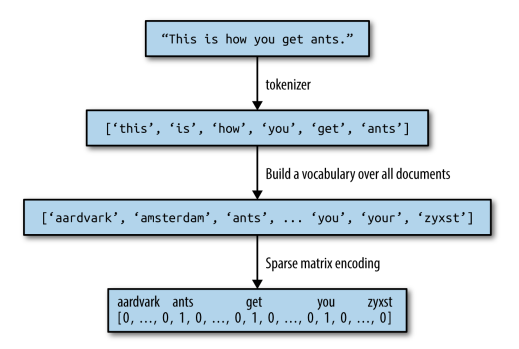

El paquete sklearn cuenta con una función llamada *CountVectorizer* que recibe una lista de documentos de texto y arma el diccionaro con las mismas. Luego podemos usar el diccionario creado para transformar listas de documentos a la representación bag-of-words.

En el bloque de código de abajo utilizamos CountVectorizer para convertir las críticas de películas al formato bag-of-words.

**Ejercicio 2.2:** Note el parámetro min_df=5 en el llamado a CountVectorizer. Este parámetro hace que en el diccionario generado sólo se incluyan palabras que aparecen en al menos 5 documentos en la base de datos. ¿Porqué cree que puede ser deseable eliminar las palabras que aparecen en menos de 5 documentos? (esto se discute en el libro, puede buscar allí, o especular)

*Inserte su respuesta aquí*

In [50]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)
X_test = vect.transform(text_test)

A continuación imprimimos los primeros 1000 elementos del vector que representa al primer documento de texto. Como el mismo está guardado en formato *sparse matrix*, esto sólo nos devuelve un indicador de cuales elementos son distintos de 0.

In [51]:
print("X_train with min_df: {}".format(repr(X_train)))
print(X_train[0,0:1000])

X_train with min_df: <25000x27271 sparse matrix of type '<class 'numpy.int64'>'
	with 3354014 stored elements in Compressed Sparse Row format>
  (0, 518)	1
  (0, 527)	1
  (0, 969)	1


**Ejercicio 2.3:** En el bloque de código anterior se ve que de los primeros mil elementos del vector del primer documento de texto, sólo 3 son diferentes que 0. ¿Qué significa esto, en términos de las palabras del documento y del diccionario que armamos?

*Inserte su respuesta aquí*

Para ilustrar, abajo extraemos las palabras del diccionario que generamos, con la función *get_feature_names*. Luego, imprimimos algunas de las palabras del diccionario

In [52]:
nombres_palabras = vect.get_feature_names()
print("Primeras 20 entradas del diccionario:\n{}".format(nombres_palabras[:20]))
print("Entradas 20010 a 20030 del diccionario:\n{}".format(nombres_palabras[20010:20030]))
print("Entradas 1, 1001, 2001, etc:\n{}".format(nombres_palabras[::1000]))

AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names'

Finalmente, usamos la representación bag-of-words de las críticas para entrenar un clasificador que determine si una crítica es positiva o negativa.

In [ ]:
from sklearn.linear_model import LogisticRegression

clasificador_opinion = LogisticRegression(max_iter=1000)
clasificador_opinion.fit(X_train, y_train)
rendimiento = clasificador_opinion.score(X_test, y_test)

print(f"El rendimiento en el set de testeo es {rendimiento*100}%")

**Extra 2.1:** Note que el modelo demora un tiempo en entrenarse. Esto es en parte por la gran cantidad de variables que tenemos (el diccionario tiene muchos miles de palabras). ¿De qué forma se le ocurre que podríamos reducir la cantidad de palabras en el diccionario para reducir el tiempo de entrenamiento, sin comprometer mucho el rendimiento? (pista: una forma involucra una de las herramientas que mencionamos más arriba, y otra manera está mencionada en el capítulo 7 del libro)

**Extra 2.2:** En el capítulo 7 hay una sección (página 341) que habla de una variante del método que usa más de una palabra, en lugar de palabras aisladas (n-Grams). Explique brevemente en qué consiste este método de los n-Grams, qué ventajas pueden tener con respecto a sólo usar las palabras aisladas, y qué dificultad puede haber en usar combinaciones de muchas palabras.